## Interact with the Env
The simplest way to create an environment and which parameters can be defined are described in `Env_Create_DEMO.ipynb`.
In this exmaple notebook we will use the described parameter dict to define a simple, small example env to learn how to interact with it.

This environment consists of a single phase electrical power grid with 1 source and 1 load as shown in the figure below:

![](figures/ExampleGrid4.png "")

To get an env consisting of that specific setting with the correct filter type and load, the parameter dict is defined in beforehand an handed over to the env.

Instead of `num_sorces` and `num_loads`, now the parameter dict and the connectivity matrix CM is used which defines if there is a connection between two nodes (e.g., source <-> load) (-> !=0) or if there is no connection (in that case the entry is `0`). For more information about the CM matrix see NodeConstructor_DEMO.ipynb.

To create a usefull example we first calulate a load which fits in case of power rating to the power the source can provied.
Therefore the function `Parallel_Load_Impedance()` provied by the Dare package is used which calulates the passive parameters for a load for specified aparant power drawn at `v_rms` (assuming 50 Hz per default - but configurable):



In [1]:
using Dare
using ReinforcementLearning

In [2]:
S_source = 200e3

S_load = 150e3
pf_load = 1
v_rms = 230
R_load, L_load, X, Z = Parallel_Load_Impedance(S_load, pf_load, v_rms)

(1.058, Inf, Inf, 1.058 + 0.0im)

Then we use these values during definiton of the env in the parameter dict.
The `control_type` of the source is chosen as `classic` in `mode => Step`. That means it is open-loop and as action a step is given to the input resulting in an input voltage of `env.nc.parameters["grid"]["v_rms"]`.
For more information about possible control modes, see `Classical_Controller_Notebook` or documentation (`LINK`)

In [3]:
CM = [0. 1.
    -1. 0.]

parameters = Dict{Any, Any}(
        "source" => Any[
                        Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Step", "fltr" => "LC"),
                        ],
        "load"   => Any[
                        Dict{Any, Any}("impedance" => "R", "R" => R_load),
                        ],
        "cable"   => Any[
                        Dict{Any, Any}("R" => 1e-3, "L" => 1e-4, "C" => 1e-4, "i_limit" => 1e4, "v_limit" => 1e4,),
                        ],
        "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.0)
    )


env = SimEnv(CM = CM, parameters = parameters)

env.state_ids

15-element Vector{String}:
 "source1_i_L1_a"
 "source1_v_C_filt_a"
 "source1_v_C_cables_a"
 "cable1_i_L_a"
 "load1_v_C_total_a"
 "source1_i_L1_b"
 "source1_v_C_filt_b"
 "source1_v_C_cables_b"
 "cable1_i_L_b"
 "load1_v_C_total_b"
 "source1_i_L1_c"
 "source1_v_C_filt_c"
 "source1_v_C_cables_c"
 "cable1_i_L_c"
 "load1_v_C_total_c"

As can be seen, the five states marked red  in the equivalent circuit diagram in the figure above can be found via the `env.state_ids`.
Analog, the `action_ids` can be found which consists only of 1 entry in case of a sinlge phase system.

In [4]:
env.action_ids


3-element Vector{String}:
 "source1_u_a"
 "source1_u_b"
 "source1_u_c"

Like described in the first env notebook, to interact with the env, the function `env(action)` can be called in a loop and the state logged during this process:

In [5]:
# run 3 steps
for _ in 1:3
    env([0.2, 0.2, 0.2])
end

env.state   # print state

15-element Vector{Float64}:
 0.06548135420290145
 0.013847803005637331
 0.01692657505439206
 0.0012287741401077802
 0.020386045162012048
 0.06548135420290141
 0.013847803005637326
 0.016926575054392053
 0.00122877414010778
 0.020386045162012048
 0.06548135420290142
 0.013847803005637335
 0.016926575054392056
 0.0012287741401077802
 0.020386045162012045

The Dare toolbox provides a more enhanced methode to run an experiment with a specific number of steps and even more episodes.
It is based in the `run` command provided by the ReinforcementLeaning.jl (https://github.com/JuliaReinforcementLearning/ReinforcementLearning.jl/blob/master/src/ReinforcementLearningCore/src/core/run.jl) toolbox and therefore can be used to `learn` a control task or to `simulate` a fixed setup  

First we take a look onto simulating the behaviour of an env without learning. Therefore the `simulate()` function from the `Dare_Wrapper` is used. 
This wrapper acts as a configuration tool to define the corresponding classic controllers and RL-agents and links inputs and outputs per controller/agent to the env states and actions depending on the `control_types` (classic or RL) and `mode`s (e.g., stepresponse (like in our example here), droop control mode,...).
In our example here, we only apply classic controllers to learn how the tool works (learning with RL agents is investigated in `RL_EXAMPLE_NOTEBOOK`). 
The interaction of the different components (env, agent, classic controllers, wrapper,...) is shown in the diagram below.



![](figures/DareWrapper.png "")


The depicted multiagent ensures that the states and actions for every source are exchanged with the correct agent or classic controller. This is depending on the `control_types` and `mode`s.
Therfore, the `setup_agents(env)` methode returns a `Multi_Agent` of type `MultiAgentGridController` which contains the different controllers and hands the correct states to the corresponding controllers to get the needed actions during the `simulate` or `learn` part.

In [6]:
Multi_Agent = setup_agents(env)

typename(MultiAgentGridController)
├─ agents => typename(Dict)
└─ action_ids => 3-element Vector{String}


Then the experiment is executed for (default) one episode. The length of the episode is defined depending on the parameter `env.maxsteps` (default = 500), which alternatively can be defined via `env.t_end` and `env.ts`. 
Inside the `simulate()` the run command (RL.base) executes 500 steps applying the defined controllers in the env.
Every step the control inputs are calulated based on the corresponding states and the env is evolved for `ts`. Then the new state is given to the controller/agent again. 

The 500 steps only gets executed if non on the defined voltage and current limits of the states are exectued (which would be equivalent to a system crash!).
In that case a flag in the env is set (`env.done = true`) which stops the episode.

To investigate the env <-> agent interaction (without learning), we now execute the `simulate` methode for one episode.

In [7]:
hook = simulate(Multi_Agent, env)

DataHook(false, "episode_data/", [-199.99999999999997 0.0 … 0.0 0.0; 0.0 -37699.11184307752 … 0.0 0.0; … ; 0.0 0.0 … -10.0 -10000.0; 0.0 0.0 … 20000.0 -18903.591682419657], [2927.9783900064085 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], Any[0.0003415325753131024, 0.00015412304086843381, 5.0e-5, 0.0001, 5.0e-5, 0.0003415325753131024, 0.00015412304086843381, 5.0e-5, 0.0001, 5.0e-5, 0.0003415325753131024, 0.00015412304086843381, 5.0e-5, 0.0001, 5.0e-5], Any[0.06830651506262048, 0.17210810076926025, 0.17210810076926025, 0.06830651506262048, 0.17210810076926025, 0.17210810076926025, 0.06830651506262048, 0.17210810076926025, 0.17210810076926025, 0.001, 0.001, 0.001], Any[1, 2, 3, 6, 7, 8, 11, 12, 13, 4, 9, 14], Any["source1_i_R1_a", "source1_i_R_C_filt_a", "source1_i_R_C_cables_a", "source1_i_R1_b", "source1_i_R_C_filt_b", "source1_i_R_C_cables_b", "source1_i_R1_c", "source1_i_R_C_filt_c", "source1_i_R_C_cables_c", "cable1_i_R_a", "cable1_i_R_b", "cable1_i_R_c"], [1], [1], Any[], An

If not defined in beforehand and handed over to the `simulate` methode, it returns a deafault `hook`. 


To collect the data - so how the states evolved over time by the chosen actions - theses hooks (https://juliareinforcementlearning.org/docs/How_to_use_hooks/) are used which will be executed at different stages of the experiment.
Via theses hooks the data to be collected is stored in a `DataFrame` labels via the state- and action_ids. This all happens using the `DataHook` provided by the Dare package.
This DataFrame can be seen in the output of the upper cell. It contains 500 rows - one for each simulated step.
In the differen colons the information about the suimulation is stored, e.g. the number of the episode, time, states, actions...
By default a `default_data_hook` is generated in the `Dare_Wapper` which collects all information about the states of the env available. 

If we are for example interested in how the state of the current through the filter inductor of source 1 (first state in the env `source1_i_L1`) evolves over time, we can grap the data like follows:

In [6]:
id = env.state_ids[1]
println(id)
hook.df[:, id]

source1_i_L1_a


500-element Vector{Float64}:
   0.0
   0.0
  64.38793241613949
 118.5118638524073
 159.6623242035541
 188.4161060129909
 206.7479466095761
 216.9637166049256
 221.29328943565338
 221.71322649159114
   ⋮
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519
 204.02614278089519

If we only want to log specific states during the experiment, a `DataHook` can be defined in beforehand.
It only has to be defined which states and actions (and others...) should be logged during initialisation. Then the `hook` has to be handed over to the `simulate()` (or `learn()`) command.

In the following we will collect all states and the action defined in the grid.
Alternatively, for example the number of source can be used to collect all the data for a specific source (compare out-commented example code). A lot of other flags can be defined to collect more measurements (RMS, reward, powers,...).
For more details we refer to the documentation and the other example notebooks.

In [10]:
hook = DataHook(collect_state_ids = env.state_ids,
                collect_action_ids = env.action_ids
                #collect_sources  = [1]  # alternative
                );

simulate(Multi_Agent, env, hook=hook)

DataHook(false, "episode_data/", [-199.99999999999997 0.0 … 0.0 0.0; 0.0 -37699.11184307752 … 0.0 0.0; … ; 0.0 0.0 … -10.0 -10000.0; 0.0 0.0 … 20000.0 -18903.591682419657], [2927.9783900064085 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], Any[0.0003415325753131024, 0.00015412304086843381, 5.0e-5, 0.0001, 5.0e-5, 0.0003415325753131024, 0.00015412304086843381, 5.0e-5, 0.0001, 5.0e-5, 0.0003415325753131024, 0.00015412304086843381, 5.0e-5, 0.0001, 5.0e-5], Any[], Any[], Any[], Any[], Any[], Any[], ["source1_i_L1_a", "source1_v_C_filt_a", "source1_v_C_cables_a", "cable1_i_L_a", "load1_v_C_total_a", "source1_i_L1_b", "source1_v_C_filt_b", "source1_v_C_cables_b", "cable1_i_L_b", "load1_v_C_total_b", "source1_i_L1_c", "source1_v_C_filt_c", "source1_v_C_cables_c", "cable1_i_L_c", "load1_v_C_total_c"], Any[], ["source1_u_a", "source1_u_b", "source1_u_c"], 500×68 DataFrame
 Row │ episode  time     source1_i_L1_a  source1_v_L1_a  source1_v_C_filt_a  s ⋯
     │ Int64    Float32  Float64     

After the experiment, the `plot_hook_results()` function provided by the Dare package can be used to show the results of the simulated episode.
Analog to the defined states and actions which are logged with the `data_hook`, states and actions to be plotted with that hook can be selected.
Here we plot all states and the action the env has - so everything we collected before:

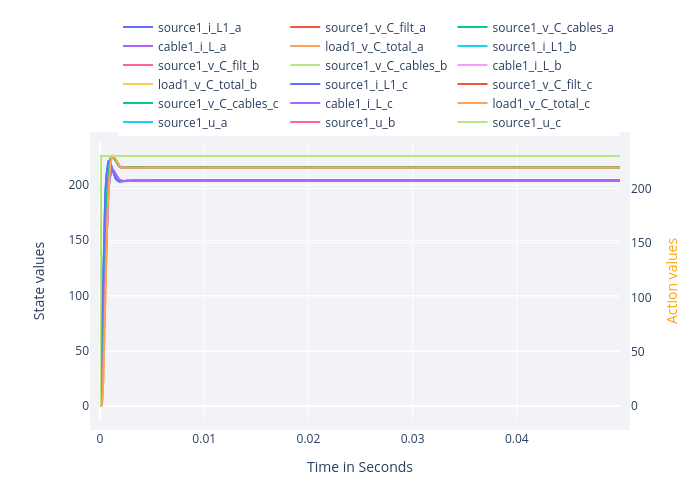

In [11]:
plot_hook_results(hook = hook, 
                    episode = 1,
                    states_to_plot  = env.state_ids,  
                    actions_to_plot = env.action_ids)

As can be seen, the states (belonging to the left y-axis) and the action (right y-axis) are plotted over the 500 timesteps while one timestep takes `ts = 1e-4` s resulting in an epiode time of 0.05 s.
As can be seen, the not normalized states and actions are plotted/collected.


## AC-grid example
To run an AC-grid where the source created a sin-wave voltage with the frequency of `env.nc.parameters["grid"]["f_grid"]` just the control mode has to be changed from `Step` to `Swing`.
Additionally the grid is changed from a single-phase to a three-phase system.

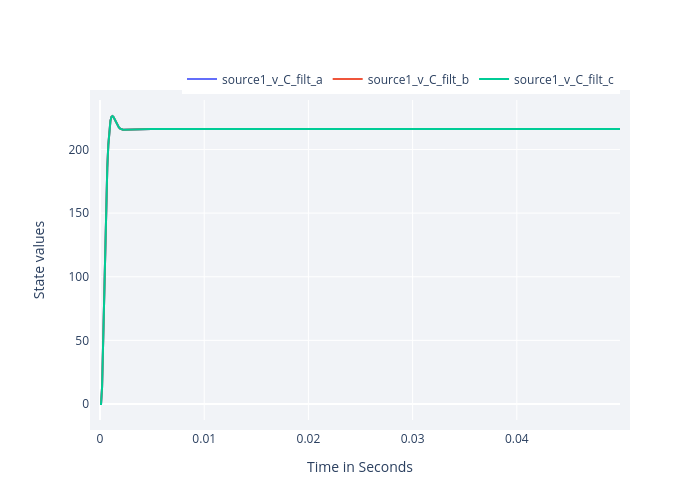

In [13]:
CM = [0. 1.
    -1. 0.]


parameters = Dict{Any, Any}(
        "source" => Any[
                        Dict{Any, Any}("pwr" => S_source, "control_type" => "classic", "mode" => "Swing", "fltr" => "LC", "i_limit" => 1e4, "v_limit" => 1e4,),
                        ],
        "load"   => Any[
                        Dict{Any, Any}("impedance" => "R", "R" => R_load)
                        ],
        "cable"   => Any[
                        Dict{Any, Any}("R" => 1e-3, "L" => 1e-4, "C" => 1e-4),
                        ],
        "grid" => Dict{Any, Any}("fs"=>1e4, "phase"=>3, "v_rms"=>230, "f_grid" => 50, "ramp_end"=>0.0)
    )

env = SimEnv(CM = CM, parameters = parameters)

states_to_plot = ["source1_v_C_filt_a", "source1_v_C_filt_b", "source1_v_C_filt_c"]

hook = DataHook(collect_state_ids = states_to_plot)

simulate(Multi_Agent, env, hook=hook)

plot_hook_results(hook = hook,
                  states_to_plot  = states_to_plot)

Based on that introdcution more enhanced environments can be created consiting of more sources and loads connected to each other
- controlled by classic grid controllers for example to chare the power based on the droop concept --> See: `Classic_Controllers_Notebooks`
- train RL agents to fullfill voltage control for single sources --> See: `TODO`
- train RL agents to interact in a bigger power grid with classically controller sources --> See: `Merge-notebook TODO`